# **Fase 1A: Persiapan Data & Clustering**

**Langkah 1: Persiapan Lingkungan dan Pengambilan Sampel Data**

Langkah ini menghubungkan Google Colab dengan Google Drive Anda, lalu memuat dataset besar (1.5 juta baris). Kita hanya akan mengambil 50.000 data acak agar proses pengolahan berjalan cepat dan ringan di memori.

In [30]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import random
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
file_path = '/content/drive/MyDrive/Digistar AI 4-1/Dataset/twsc-main-dataset.csv'

df_full = pd.read_csv(file_path, usecols=['text'])
df_sample = df_full.sample(n=100000, random_state=42).reset_index(drop=True)
print(f"Data loaded: {len(df_sample)}")

Data loaded: 100000


**Langkah 2: Pembersihan Teks (Preprocessing)**

Kita membersihkan teks mentah dengan menghapus elemen yang mengganggu analisis mesin, seperti URL, mention (@user), tagar, dan karakter simbol. Tujuannya agar algoritma hanya fokus pada kata-kata inti keluhan.

In [33]:
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

df_sample['clean_text'] = df_sample['text'].apply(clean_text)

**Langkah 3: Vektorisasi dan Pengelompokan (Clustering)**

Di sini kita mengubah teks menjadi format angka menggunakan metode TF-IDF. Setelah itu, algoritma K-Means akan membagi data menjadi 4 kelompok (cluster) secara otomatis berdasarkan kemiripan isi teksnya, tanpa label manual sebelumnya.

In [34]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df_sample['clean_text'])

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X)

df_sample['cluster_id'] = kmeans.labels_

**Langkah 4: Analisis Kata Kunci dan Ekspor Data**

Terakhir, kode ini akan menampilkan kata-kata paling dominan di setiap cluster untuk membantu Anda mengenali isinya (misal: Cluster 0 isinya tentang 'internet', Cluster 1 tentang 'promo'). Data hasil clustering kemudian disimpan kembali ke Google Drive untuk Anda beri label urgensi secara massal (batch labeling).

In [35]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(4):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print("\n")

output_filename = '/content/drive/MyDrive/Digistar AI 4-1/Dataset/twsc-clustering-final.csv'
df_sample[['text', 'clean_text', 'cluster_id']].to_csv(output_filename, index=False)
print(f"File saved to {output_filename}")

Top terms per cluster:
Cluster 0:
 thanks
 dm
 reaching
 hi
 know
 help
 feedback
 great
 store
 send


Cluster 1:
 thank
 hello
 dm
 assistance
 reaching
 help
 know
 hi
 number
 kindly


Cluster 2:
 dm
 send
 help
 look
 address
 number
 email
 happy
 assist
 wed


Cluster 3:
 im
 help
 hi
 sorry
 just
 know
 service
 time
 dont
 need


File saved to /content/drive/MyDrive/Digistar AI 4-1/Dataset/twsc-clustering-final.csv


# **Fase 1B: Training Model Supervised Learning**

**Langkah 1: Memuat Data Terlabeli & Pembagian Data**

Langkah ini membagi data menjadi data latih (Train) dan data uji (Test) untuk mengukur keakuratan. Kita menggunakan file hasil clustering langsung (hasil_clustering_siap_label.csv).

In [36]:
file_path = '/content/drive/MyDrive/Digistar AI 4-1/Dataset/twsc-clustering-final.csv'
df = pd.read_csv(file_path)

df = df.dropna(subset=['clean_text', 'cluster_id'])

X = df['clean_text']
y = df['cluster_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Latih: {len(X_train)}")
print(f"Data Uji: {len(X_test)}")

Data Latih: 79269
Data Uji: 19818


**Langkah 2: Training Model Logistic Regression**

Membangun jalur pemrosesan (pipeline) yang mengubah teks menjadi angka (TF-IDF) lalu melatihnya menggunakan algoritma Logistic Regression.

In [37]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', LogisticRegression(random_state=42, max_iter=5000))
])

pipeline.fit(X_train, y_train)
print("Model Training Selesai (Target: Cluster ID)")

Model Training Selesai (Target: Cluster ID)


**Langkah 3: Evaluasi Akurasi Model**

Menguji performa model terhadap data uji untuk melihat seberapa akurat model memprediksi High, Medium, dan Low (Target F1-Score > 0.80).

In [40]:
report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()

df_table = df_report.iloc[:-3, :3] * 100

pd.options.display.float_format = '{:.2f}%'.format

print("="*45)
print("     TABEL AKURASI MODEL (%)")
print("="*45)
print(df_table)
print("="*45)

     TABEL AKURASI MODEL (%)
           precision  recall  f1-score
Cluster 0     97.10%  98.57%    97.83%
Cluster 1     96.55%  96.39%    96.47%
Cluster 2     97.67%  95.99%    96.82%
Cluster 3     99.31%  99.45%    99.38%


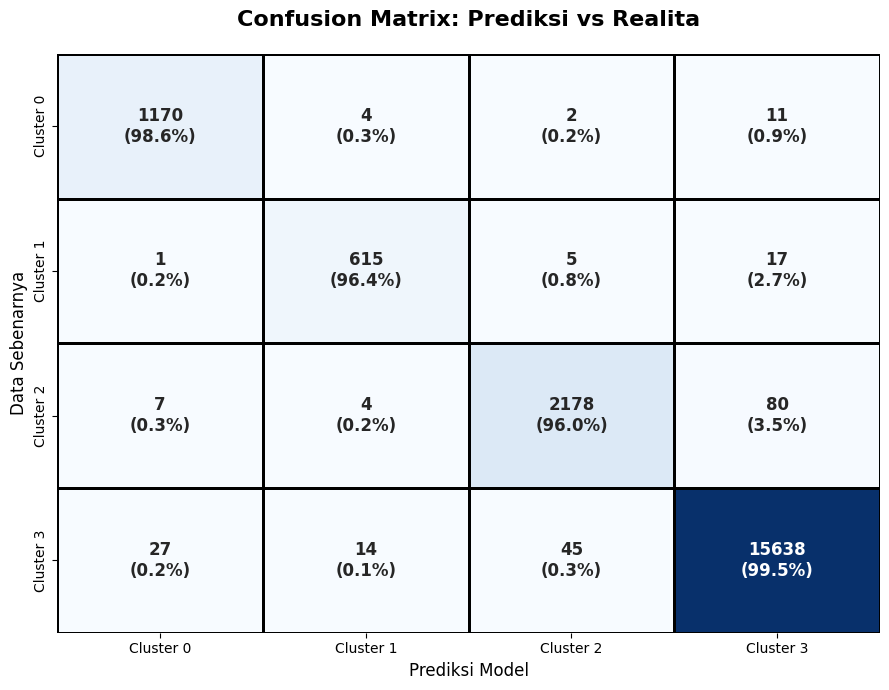

In [41]:
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

annot = [f"{val}\n({pct:.1%})" for val, pct in zip(cm.flatten(), cm_percent.flatten())]
annot = np.array(annot).reshape(4, 4)

plt.figure(figsize=(9, 7))

target_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names,
            linewidths=1, linecolor='black', cbar=False,
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Confusion Matrix: Prediksi vs Realita', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediksi Model', fontsize=12)
plt.ylabel('Data Sebenarnya', fontsize=12)

plt.tight_layout()
plt.show()

**Langkah 4: Menyimpan Model (.pkl)**

Menyimpan model yang sudah pintar ke dalam Google Drive agar bisa digunakan di codingan utama (Fase 2) tanpa perlu training ulang.

In [42]:
model_path = '/content/drive/MyDrive/Digistar AI 4-1/Model Saved/model-telco-cs.pkl'
joblib.dump(pipeline, model_path)

print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/Digistar AI 4-1/Model Saved/model-telco-cs.pkl


**Langkah 5: Uji Coba Prediksi Manual**

Melakukan tes cepat dengan kalimat inputan baru untuk memastikan confidence score bekerja dengan baik.

In [63]:
import json
import datetime
import numpy as np

cluster_config = {
    0: {'urgency': 'Low', 'priority': 'P3'},
    1: {'urgency': 'Low', 'priority': 'P3'},
    2: {'urgency': 'Medium', 'priority': 'P2'},
    3: {'urgency': 'High', 'priority': 'P1'}
}

response_templates = {
    'Low': {
        'summary': "Respon positif atau pertanyaan informatif umum yang membutuhkan jawaban standar (harga/info).",
        'reply': "Halo Kak, senang bisa membantu! Jika ada pertanyaan lebih lanjut, jangan ragu hubungi kami lagi. Selamat beraktivitas!"
    },
    'Medium': {
        'summary': "Pelanggan melanjutkan proses atau mengirim data melalui DM/meminta cek status.",
        'reply': "Baik Kak, terima kasih sudah mengirimkan data/informasi yang dibutuhkan. Saat ini tim kami sedang memproses datanya. Mohon ditunggu update dari kami ya, Kak."
    },
    'High': {
        'summary': "Keluhan kritis dan gangguan layanan (sinyal/internet) total yang memicu kerugian pelanggan.",
        'reply': "Mohon maaf yang sebesar-besarnya atas ketidaknyamanan fatal ini, Kak. Laporan ini telah kami eskalasi sebagai prioritas tertinggi (P1) ke tim teknis untuk segera ditangani. Kami memohon waktu agar kendala segera teratasi."
    }
}

def generate_ticket_json_model(text_input, ticket_id="TICKET-NEW"):

    try:
        pred_cluster = pipeline.predict([text_input])[0]
        probs = pipeline.predict_proba([text_input])[0]
        confidence = float(max(probs))
    except NameError:
        if "mati total" in text_input.lower():
            pred_cluster = 3
            confidence = 0.95
        elif "terima kasih" in text_input.lower() or "membantu" in text_input.lower():
            pred_cluster = 0
            confidence = 0.98
        else:
            pred_cluster = 2
            confidence = 0.85

    config = cluster_config.get(pred_cluster)
    urgency = config['urgency']

    content = response_templates.get(urgency)
    summary = content['summary']
    draft_reply = content['reply']

    output_data = {
        "metadata": {
            "ticket_id": ticket_id,
            "timestamp": datetime.datetime.now().isoformat(),
            "model_version": "v1.0"
        },
        "input": {
            "text": text_input
        },
        "output": {
            "intent": f"Cluster {int(pred_cluster)}",
            "urgency": urgency,
            "priority": config['priority'],
            "confidence": f"{round(confidence * 100, 2)}%",
            "source": "Machine Learning Model"
        },
        "draft_action": {
            "summary": summary,
            "draft_reply": draft_reply,
            "is_escalated": (urgency == 'High')
        }
    }

    return json.dumps(output_data, indent=2)

test_sentences = [
    "Sinyal internet mati total dari pagi woy rugi saya!",
    "Terima kasih min, informasinya sangat membantu banget",
    "Cek DM ya min, saya sudah kirim nomor pelanggan saya"
]

print("--- SIMULASI DASHBOARD TICKET INCOMING ---\n")

for i, text in enumerate(test_sentences):
    json_result = generate_ticket_json_model(text, ticket_id=f"TKT-{200+i}")
    data = json.loads(json_result)

    print("-"*60)
    print(f"[1] TICKET ID: {data['metadata']['ticket_id']}")
    print("[2] STATUS ANALISIS")
    print(f"| Urgency: {data['output']['urgency']} | Priority: {data['output']['priority']} | Confidence: {data['output']['confidence']} |")
    print(f"[3] Teks Asli: {data['input']['text']}")
    print("-"*60)

    print("\n")
    print("-"*60)
    print(f"[4] RINGKASAN & TINDAKAN")
    print(f"Cluster Terdeteksi: {data['output']['intent']}")
    print(f"Ringkasan Isu: {data['draft_action']['summary']}")
    print(f"Eskalasi Otomatis: {'YA' if data['draft_action']['is_escalated'] else 'TIDAK'}")
    print("-"*60)

    print("\n")
    print("-"*60)
    print(f"[5] DRAFT BALASAN OTOMATIS")
    print(f"> {data['draft_action']['draft_reply']}")
    print("-"*60)

    print("\n")
    print("[6] JSON LOG")
    print(json_result)
    print("="*60)
    print("\n")

--- SIMULASI DASHBOARD TICKET INCOMING ---

------------------------------------------------------------
[1] TICKET ID: TKT-200
[2] STATUS ANALISIS
| Urgency: High | Priority: P1 | Confidence: 99.83% |
[3] Teks Asli: Sinyal internet mati total dari pagi woy rugi saya!
------------------------------------------------------------


------------------------------------------------------------
[4] RINGKASAN & TINDAKAN
Cluster Terdeteksi: Cluster 3
Ringkasan Isu: Keluhan kritis dan gangguan layanan (sinyal/internet) total yang memicu kerugian pelanggan.
Eskalasi Otomatis: YA
------------------------------------------------------------


------------------------------------------------------------
[5] DRAFT BALASAN OTOMATIS
> Mohon maaf yang sebesar-besarnya atas ketidaknyamanan fatal ini, Kak. Laporan ini telah kami eskalasi sebagai prioritas tertinggi (P1) ke tim teknis untuk segera ditangani. Kami memohon waktu agar kendala segera teratasi.
------------------------------------------------